In [5]:
from google.colab import files

uploaded = files.upload()

Saving dataset_no_zeros.csv to dataset_no_zeros.csv


In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9921924791390074505
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12614281023968923398
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [7]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [8]:
import pandas as pd

data = pd.read_csv('dataset_no_zeros.csv')
data.head()


,Unnamed: 0,study_id,Pleural Effusion,report
0,3,50000103,1.0,FINAL REPORT\...
1,6,50000186,1.0,FINAL REPORT\...
2,15,50000801,-1.0,FINAL REPORT\...
3,25,50001349,1.0,FINAL REPORT\...
4,38,50001872,-1.0,FINAL REPORT\...


In [9]:
# separate reports and labels, set label values to 0(no) and 1 (yes), cast to integer(float is annoying)
texts = data['report']
labels = data['Pleural Effusion']
labels = labels.replace(1.0, 1)
labels = labels.replace(-1.0, 0)
labels = labels.astype('int')
texts.head()




0                                     FINAL REPORT\...
1                                     FINAL REPORT\...
2                                     FINAL REPORT\...
3                                     FINAL REPORT\...
4                                     FINAL REPORT\...
Name: report, dtype: object

((42079,), (42079,), (6493,), (6493,), (11542,), (11542,))

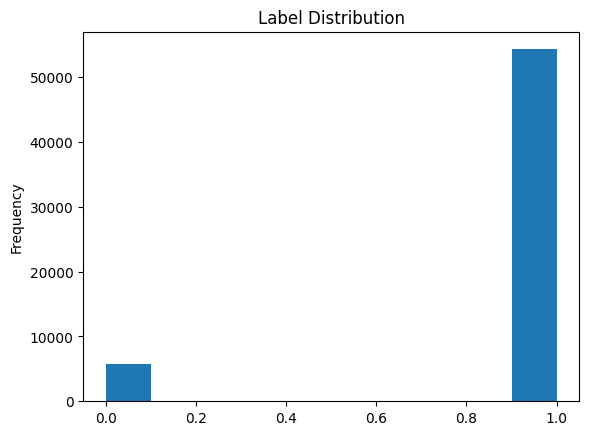

In [10]:
#split into train and test 90/10, let the test be, split train later again into train and val
from sklearn.model_selection import train_test_split

labels.plot(kind  = 'hist', title = 'Label Distribution')
x_train, x_test, y_train, y_test = train_test_split(texts, labels,  stratify=labels, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,  stratify=y_test, test_size=0.36)
x_train.shape,  y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape


In [15]:
x_train[5]



'                                 FINAL REPORT\n INDICATION:  History: ___F with R-sided chest pain  // r/o ptx vs. pneumonia\n \n COMPARISON:  Multiple prior exams, most recently chest radiograph of ___.\n \n TECHNIQUE:  Frontal and lateral views of the chest.\n \n FINDINGS: \n \n Heart size is top normal and mediastinal contours are stable. Calcification of\n the aortic knob is similar to prior. Upper lung fibrotic changes are similar\n to prior.  Mild blunting of the posterior costophrenic angles are consistent\n with small bilateral pleural effusions. No focal consolidation or\n pneumothorax.\n \n IMPRESSION: \n \n Small bilateral pleural effusions. No focal consolidation or pneumothorax.\n'

In [17]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
print(' Original: ', x_train[5])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(x_train[5]))



 Original:                                   FINAL REPORT
 INDICATION:  History: ___F with R-sided chest pain  // r/o ptx vs. pneumonia
 
 COMPARISON:  Multiple prior exams, most recently chest radiograph of ___.
 
 TECHNIQUE:  Frontal and lateral views of the chest.
 
 FINDINGS: 
 
 Heart size is top normal and mediastinal contours are stable. Calcification of
 the aortic knob is similar to prior. Upper lung fibrotic changes are similar
 to prior.  Mild blunting of the posterior costophrenic angles are consistent
 with small bilateral pleural effusions. No focal consolidation or
 pneumothorax.
 
 IMPRESSION: 
 
 Small bilateral pleural effusions. No focal consolidation or pneumothorax.

Tokenized:  ['final', 'report', 'indication', ':', 'history', ':', '_', '_', '_', 'f', 'with', 'r', '-', 'sided', 'chest', 'pain', '/', '/', 'r', '/', 'o', 'pt', '##x', 'vs', '.', 'pneumonia', 'comparison', ':', 'multiple', 'prior', 'exams', ',', 'most', 'recently', 'chest', 'radio', '##graph', 'of', '

In [19]:
#Convert train examples into numeric tokens
token_ids_train = []
for text in x_train:
   encoded_text = tokenizer.encode(
                        text,
                        add_special_tokens = True)
   token_ids_train.append(encoded_text)



Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors


In [20]:
x_train = x_train.reset_index(drop=True) # Reset the indexes. Otherwise it doesn't have normal running numbers
x_train.head()
print('Original: ', x_train[0])
print('Token IDs:', token_ids_train[0])
tokenized = tokenizer.tokenize(x_train[0])
print(tokenized, len(token_ids_train[0]))
print('Max sentence length: ', max([len(t) for t in token_ids_train]))
  # tokenized_ex = tokenized_ex[-512:] if (len(tokenized_ex))>512 else tokenized_ex

Original:                                   FINAL REPORT
 EXAMINATION:  CHEST (PORTABLE AP)
 
 INDICATION:  ___ year old man with acute on chronic respiratory distress, known
 cancer mets to lung  // Evaluate for new acute process
 
 COMPARISON:  Chest radiographs on ___.
 
 IMPRESSION: 
 
 Mild interstitial abnormality on ___ has improved, presumably edema. The
 multiple lung nodules seen on the upper images of the abdomen CT ___ are
 not as distinct today as they were were on the concurrent chest radiograph.
 Smaller nodules are seen in the left perihilar lung, right upper lung is
 clear. Moderately severe bibasilar atelectasis is unchanged. Mild cardiomegaly
 is stable. Pleural effusion is small if any. No pneumothorax.

Token IDs: [101, 2345, 3189, 7749, 1024, 3108, 1006, 12109, 9706, 1007, 12407, 1024, 1035, 1035, 1035, 2095, 2214, 2158, 2007, 11325, 2006, 11888, 16464, 12893, 1010, 2124, 4456, 15253, 2000, 11192, 1013, 1013, 16157, 2005, 2047, 11325, 2832, 7831, 1024, 3108, 2557,

In [21]:
#Convert val examples into numeric tokens

token_ids_val = []
for text in x_val:
   encoded_text = tokenizer.encode(
                        text,
                        add_special_tokens = True)
   token_ids_val.append(encoded_text)

In [22]:
x_val = x_train.reset_index(drop=True) # Reset the indexes. Otherwise it doesn't have normal running numbers
x_val.head()


0                                     FINAL REPORT\...
1                                     FINAL REPORT\...
2                                     FINAL REPORT\...
3                                     FINAL REPORT\...
4                                     FINAL REPORT\...
Name: report, dtype: object

In [33]:
some_list = []
some_list.append("102")
some_list.insert(0, 101)

some_list


[101, '102']

In [54]:
#Trim the tokenized train data to 128
new_ids_train = []
for t in token_ids_train:
  if len(t) > 128:
    n = t[-128:]
    new_ids_train.append(n)

  else:
    new_ids_train.append(t)


print('Max sentence length: ', max([len(t) for t in new_ids_train]))


Max sentence length:  128


In [53]:
#Trim the tokenized train data to 128
new_ids_val = []
for t in token_ids_val:
  if len(t) > 128:
    n = t[-128:]
    new_ids_val.append(n)
  else:
    new_ids_val.append(t)


print('Max sentence length: ', max([len(t) for t in new_ids_val]))


Max sentence length:  128


<Axes: >

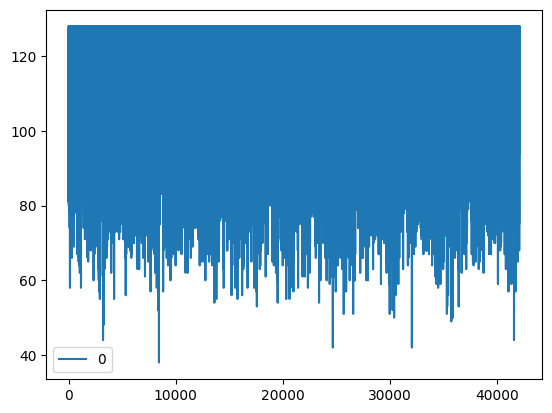

In [55]:
lengths = [len(t) for t in new_ids_train]
pd.DataFrame(lengths).plot()


In [56]:
#padding
from keras.preprocessing.sequence import pad_sequences

new_ids_train = pad_sequences(new_ids_train, maxlen=128, dtype="long",
                          value=0, truncating="post", padding="post")


new_ids_val = pad_sequences(new_ids_val, maxlen=128, dtype="long",
                          value=0, truncating="post", padding="post")

In [47]:
print(new_ids_val[8])

[  101  3108  1006 12109  9706  1007 12407  1024  1035  1035  1035  2095
  2214  2450  2007  2004  2682  1013  1013  1055  1013  1052 20118 28228
  2278  7905  6110  1059  1013  3445  2460  2791  1997  3052  1025  1054
  1013  1051  1041  4246 14499  1013 13866  2595  1055  1013  1052 20118
 28228  2278  7905  6110  1059  1013  3445  2460  2791  1997  3052  1025
  1054  1013  1051  1041  4246 14499  1013 13866  2595  8605  1024  4003
 18994  2098  7951 13770  2140 17973  2003  6540  1010  2157  2896 21833
 19470  3012  3504  2062  2066  8823  2571 25572  6190  1012  2187  2896
 21833  8823  2571 25572  6190  2038 27622  5642  2011  2235  2187 20228
 11236  2389  1041  4246 14499  1012  2053 21908  3968 14545  1012  2053
  1052  2638  2819 29288  2527  2595  1012   102]


In [57]:
attention_masks_train = []

for token in new_ids_train:

    # Create the attention mask.
    att_mask = [int(token_id > 0) for token_id in token]

    # Store the attention mask for this sentence.
    attention_masks_train.append(att_mask)

In [58]:
attention_masks_val = []

for token in new_ids_val:

    # Create the attention mask.
    att_mask = [int(token_id > 0) for token_id in token]

    # Store the attention mask for this sentence.
    attention_masks_val.append(att_mask)

In [59]:
y_val = y_val.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)



#split: possibly, there is a precision problem, make the split in the beginning
# from sklearn.model_selection import train_test_split

# labels_np = y_train.to_numpy() # it doesn't like the Series to torch

# x_train, x_val, y_train, y_val = train_test_split(new_ids, labels_np,  stratify=labels_np, random_state = 100, test_size=)
# train_masks, val_masks, _, _ = train_test_split(attention_masks, labels_np, stratify=labels_np, random_state=100, test_size=)

# x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, stratify=y_test, random_state = 100, test_size=test_ratio/(test_ratio + validation_ratio))
# val_masks, test_masks, _, _ = train_test_split(test_masks, y_test, stratify=y_test, random_state=100, test_size=test_ratio/(test_ratio + validation_ratio))


# train_masks, test_masks, _, _ = train_test_split(attention_masks, labels_np, stratify=labels_np, random_state=100, test_size=0.1)

In [60]:
import torch

input_train = torch.tensor(new_ids_train)
input_test = torch.tensor(new_ids_val)

labels_train = torch.tensor(y_train)
labels_test = torch.tensor(y_val)

train_masks = torch.tensor(attention_masks_train)
test_masks = torch.tensor(attention_masks_val)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# DataLoader for our training set.
train_data = TensorDataset(input_train, train_masks, labels_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(input_test, test_masks, labels_test)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# load model for classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# AdamW optimizer, maybe from another module?
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# Helper funtion to track time and validation

import numpy as np
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')

    # Measure how long the training epoch takes.
  t0 = time.time()

    # Reset the total loss for this epoch.
  total_loss = 0
  model.train()

    # For each batch of training data...
  for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

            # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad() # set gradients to zero manually

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  # Calculate the average loss over the training data.
  avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
  loss_values.append(avg_train_loss)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


    #               Validation
    # After the completion of each training epoch, measure our performance on
    # our validation set.

  print("")
  print("Running Validation...")

  t0 = time.time()

  # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
  model.eval()

    # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
  for batch in validation_dataloader:


        # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
    with torch.no_grad():
      outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)
    logits = outputs[0]

        # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
    nb_eval_steps += 1

  print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,315.    Elapsed: 0:00:25.
  Batch    80  of  1,315.    Elapsed: 0:00:50.
  Batch   120  of  1,315.    Elapsed: 0:01:14.
  Batch   160  of  1,315.    Elapsed: 0:01:39.
  Batch   200  of  1,315.    Elapsed: 0:02:05.
  Batch   240  of  1,315.    Elapsed: 0:02:31.
  Batch   280  of  1,315.    Elapsed: 0:02:57.
  Batch   320  of  1,315.    Elapsed: 0:03:23.
  Batch   360  of  1,315.    Elapsed: 0:03:49.
  Batch   400  of  1,315.    Elapsed: 0:04:16.
  Batch   440  of  1,315.    Elapsed: 0:04:43.
  Batch   480  of  1,315.    Elapsed: 0:05:09.
  Batch   520  of  1,315.    Elapsed: 0:05:36.
  Batch   560  of  1,315.    Elapsed: 0:06:03.
  Batch   600  of  1,315.    Elapsed: 0:06:30.
  Batch   640  of  1,315.    Elapsed: 0:06:57.
  Batch   680  of  1,315.    Elapsed: 0:07:24.
  Batch   720  of  1,315.    Elapsed: 0:07:51.
  Batch   760  of  1,315.    Elapsed: 0:08:18.
  Batch   800  of  1,315.    Elapsed: 0:08:45.
  Batch   840  of

In [ ]:
#preprocess test data
token_ids_test = []
for text in x_test:
   encoded_text = tokenizer.encode(
                        text,
                        add_special_tokens = True)
   token_ids_test.append(encoded_text)


   x_test = x_test.reset_index(drop=True)
   y_test = y_test.reset_index(drop=True)

   new_ids_test = []
for t in token_ids_test:
  if len(t) > 128:
    n = t[-128:]
    new_ids_test.append(n)
  else:
    new_ids_test.append(t)


new_ids_test = pad_sequences(new_ids_test, maxlen=128, dtype="long",
                          value=0, truncating="post", padding="post")

In [ ]:
attention_masks_test = []

for seq in new_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(new_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(y_test)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [ ]:
# Specify a path
PATH = "state_dict_model.pt"

# Save
torch.save(model.state_dict(), PATH)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


print('Positive samples: %d of %d (%.2f%%)' % (y_test.sum(), len(y_test), (y_test.sum() / len(y_test) * 100.0)))

Predicting labels for 6,493 test sentences...
    DONE.
Positive samples: 5865 of 6493 (90.33%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
matthews_set

[-0.03225806451612903,
 0.8958064164776167,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6956083436402525,
 1.0,
 1.0,
 0.8958064164776167,
 0.8509629433967631,
 1.0,
 -0.04637388957601683,
 0.6956083436402525,
 1.0,
 1.0,
 1.0,
 0.8509629433967631,
 1.0,
 0.52678658400752,
 0.6956083436402525,
 0.6956083436402525,
 0.8509629433967631,
 0.8958064164776167,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.8509629433967631,
 1.0,
 1.0,
 0.6753002216523571,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8783100656536799,
 1.0,
 0.8783100656536799,
 1.0,
 0.0,
 0.6956083436402525,
 1.0,
 0.6956083436402525,
 1.0,
 0.6831300510639733,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.6956083436402525,
 1.0,
 1.0,
 0.6956083436402525,
 1.0,
 1.0,
 0.8783100656536799,
 1.0,
 0.8958064164776167,
 0.8509629433967631,
 0.8509629433967631,
 1.0,
 1.0,
 0.6956083436402525,
 1.0,
 0.0,
 1.0,
 0.6831300510639733,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8027729719194864,
 1.0,
 0.6956083436402525,
 1.0,
 0.8958064164776167,
 1.0,
 0.85

In [ ]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.913
